In [1]:
import umap
import torch
from torch.functional import F
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from common import h5dataset, model_dnn

c:\Users\sollb\Documents\fhnw\ip5\IP5-Jass-AI\training\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET_PATH = '../log_parser/dataset/flat_playing.hdf5'
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}")

MODLE_PATH = './models/'
if not os.path.exists(MODLE_PATH):
    os.makedirs(MODLE_PATH)


In [3]:
BATCH_SIZE = 256
NUM_ACTIONS = 9
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
dataset = h5dataset.H5Dataset(DATASET_PATH)
train_dataset, val_dataset = dataset.split(0.99)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# Load model
model_gan = model_dnn.ModelDNN(
    "JassPlayGen",
    input_size=72,
    embedding_size=13,
    hidden_size=[512, 256, 128],
    output_size=9,
)
model_gan.load_state_dict(torch.load(os.path.join(MODLE_PATH, 'play_gan', 'JassGanGen_512_256_128_dnn.pth')))
model_gan.to(device)
model_gan.eval()
model_sl = model_dnn.ModelDNN(
    "JassPlaySL",
    input_size=72,
    embedding_size=13,
    hidden_size=[512, 256, 128],
    output_size=9,
)
model_sl.load_state_dict(torch.load(os.path.join(MODLE_PATH, 'play', 'JassPlay_512_256_128_dnn.pth')))
model_sl.to(device) 
model_sl.eval()


ModelDNN(
  (embedding): Embedding(37, 13)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=936, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=9, bias=True)
  )
)

In [4]:
# Containers
real_vecs = []
gan_vecs = []
sl_vecs = []
labels = []

# Run inference and collect state + one-hot-action pairs
with torch.no_grad():
    for state, action in tqdm(val_loader, desc=f"Creating vectors", unit="batch"):
        state, action = state.to(device), action.to(device)

        # Get action predictions
        gan_logits = model_gan(state)
        sl_logits = model_sl(state)

        gan_actions = gan_logits.argmax(dim=1)
        sl_actions = sl_logits.argmax(dim=1)

        # Convert actions to one-hot
        targets_oh = F.one_hot(action.view(-1), num_classes=NUM_ACTIONS).float()
        gan_oh = F.one_hot(gan_actions.view(-1), num_classes=NUM_ACTIONS).float()
        sl_oh = F.one_hot(sl_actions.view(-1), num_classes=NUM_ACTIONS).float()

        # Combine input (state) with action vector
        real_combined = torch.cat([state.cpu(), targets_oh.cpu()], dim=1)
        gan_combined = torch.cat([state.cpu(), gan_oh.cpu()], dim=1)
        sl_combined = torch.cat([state.cpu(), sl_oh.cpu()], dim=1)

        # Store
        real_vecs.append(real_combined)
        gan_vecs.append(gan_combined)
        sl_vecs.append(sl_combined)

        labels.extend(["real"] * len(state))
        labels.extend(["gan"] * len(state))
        labels.extend(["sl"] * len(state))

real_vecs = torch.cat(real_vecs, dim=0).numpy()
gan_vecs = torch.cat(gan_vecs, dim=0).numpy()
sl_vecs = torch.cat(sl_vecs, dim=0).numpy()



Creating vectors: 100%|██████████| 867/867 [00:05<00:00, 162.40batch/s]


In [5]:
all_vecs = np.vstack([real_vecs, gan_vecs, sl_vecs])
umap.tqdm_progress = tqdm(total=all_vecs.shape[0], desc="UMAP embedding", unit="sample")
reducer = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2)
embedding = reducer.fit_transform(all_vecs)

UMAP embedding:   0%|          | 0/665559 [00:00<?, ?sample/s]c:\Users\sollb\Documents\fhnw\ip5\IP5-Jass-AI\training\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


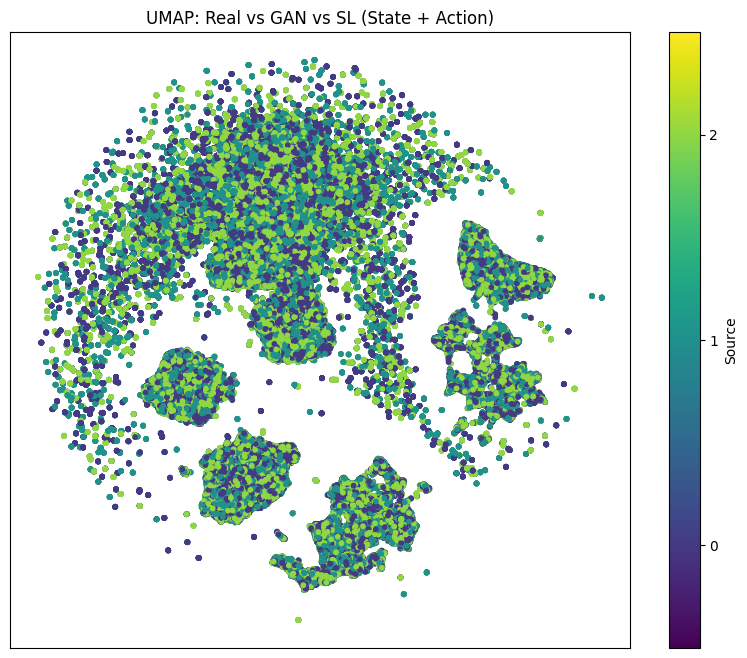

In [6]:
label_to_color = {"real": 0, "gan": 1, "sl": 2}
numeric_labels = [label_to_color[label] for label in labels]

# Plot directly with matplotlib
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=numeric_labels, cmap="viridis", s=10)
plt.title("UMAP: Real vs GAN vs SL (State + Action)")
plt.colorbar(scatter, ticks=[0, 1, 2], label='Source')
plt.clim(-0.5, 2.5)
plt.xticks([])
plt.yticks([])
plt.show()